In [1]:
import pandas as pd

df = pd.read_pickle('data/pubmed_longevity.pkl')

In [2]:
import string
import ast

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH

from textsemantics import specific_words
from utils.cluster_utils import find_cluster_words

import numpy as np
from umap import UMAP
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import Markdown, display

from sklearn.feature_extraction.text import TfidfVectorizer
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from sklearn.mixture import GaussianMixture
from collections import Counter

In [3]:
%%time
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
texts = [' '.join(t) for t in tokens_list if len(t) > 0]
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

2021-04-08 10:07:45,966 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:46,868 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:48,054 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:48,448 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:48,581 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:49,628 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-08 10:07:51,010 Warning: An empty Sentence was created! Are there empty strings in your dataset?
CPU times: user 56 s, sys: 7.75 s, total: 1min 3s
Wall time: 1min 36s


Number of clusters: 6, Noise: 11


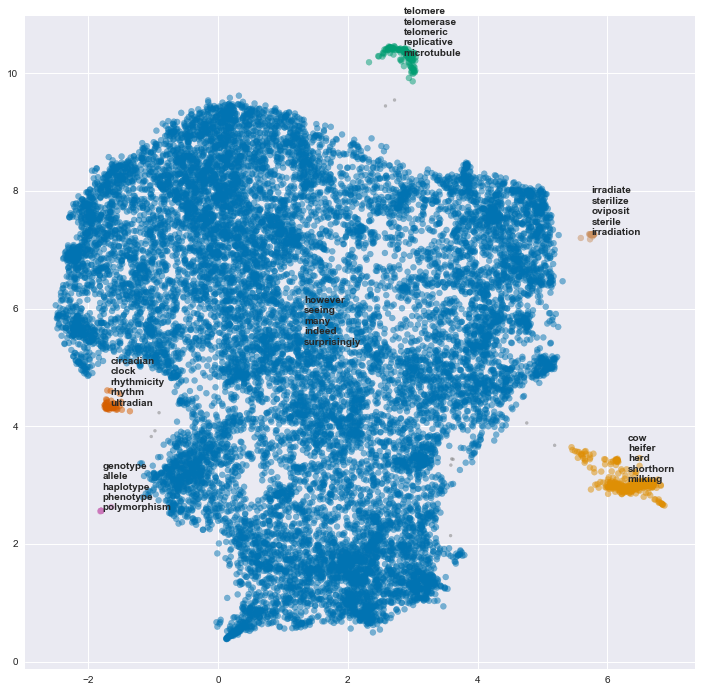

In [4]:
plt.figure(figsize=(12, 12))
plt.style.use('seaborn')

umap = UMAP(random_state=0).fit(doc_embs)

dbscan = DBSCAN(eps=0.2).fit(umap.embedding_)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
palette = sns.color_palette('colorblind', n_clusters)
print(f"Number of clusters: {n_clusters}, Noise: {n_noise}")


cluster_describer = find_cluster_words(doc_embs, word_embs, dbscan.labels_)

cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in dbscan.labels_]
s = [36 if l > -1 else 9 for l in dbscan.labels_]
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=cs,
            alpha=0.5, s=s);

for cluster, words in cluster_describer.items():
    centroid = np.mean(umap.embedding_[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(cluster_describer[cluster][:5])
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})


In [5]:
md = ''
for cluster, desc in cluster_describer.items():
    docs = np.where(labels == cluster)[0]
    negative = np.where(labels != cluster)[0]
    titles = df['title'].iloc[negative]

    idx = list()
    for kw in desc[:10]:
        idx.extend(t for t in titles if kw in t)

    other = len(set(idx))
    md += f'\n## Cluster {cluster}  - {len(docs)} documents \n'
    md += f'### Keywords: {", ".join(desc[:10])}\n'
    md += f'#### Keywords in titles of other clusters: {other}\n'
    
    for doc in docs[:10]:
        md += f"- {df['title'].iloc[doc]}\n"

display(Markdown(md))


## Cluster 0  - 16247 documents 
### Keywords: however, seeing, many, indeed, surprisingly, yet, nevertheless, potentially, following, seemingly
#### Keywords in titles of other clusters: 4
- The practice of self-preserving behavior of the citizen of the Russian Federation: the results of the All-Russian sociological study "The demographic self-feeling of Russia"
- Efficacy, longevity, and bleaching sensitivity of carbamide and hydrogen peroxides for in-office bleaching: A 6-month randomized, double blind, split-mouth clinical trial.
- Consumption of field-realistic doses of a widely used mito-toxic fungicide reduces thorax mass but does not negatively impact flight capacities of the honey bee (Apis mellifera).
- Calcium channel ITPR2 and mitochondria-ER contacts promote cellular senescence and aging.
- Analysis of distribution characteristics and influencing factors of healthy and long-lived people in Shanglin area of Nanning, Guangxi Zhuang Autonomous Region
- The study on the distribution characteristics and relevant factors of healthy and long-lived people in multiple regions of Guangxi Zhuang Autonomous Region
- SVIP is a molecular determinant of lysosomal dynamic stability, neurodegeneration and lifespan.
- Casein-maltodextrin Maillard conjugates encapsulation enhances the antioxidative potential of proanthocyanidins: An in vitro and in vivo evaluation.
- Aging and Senescence across Reproductive Traits and Survival in Superb Fairy-Wrens (Malurus cyaneus).
- Steroid hormones sulfatase inactivation extends lifespan and ameliorates age-related diseases.

## Cluster 1  - 324 documents 
### Keywords: cow, heifer, herd, shorthorn, milking, calf, milker, dairy, cattle, pasture
#### Keywords in titles of other clusters: 25
- Comparison of performance of F1 Romanov crossbred ewes with wool and hair breeds during fall lambing and body weight and longevity through six production years.
- Invited review: Academic and applied approach to evaluating longevity in dairy cows.
- Changes in milk lactose content as indicators for longevity and udder health in Holstein cows.
- An index framework founded on the future profit potential of female beef cattle to aid the identification of candidates for culling.
- Apgar score or birthweight in Chihuahua dogs born by elective Caesarean section: which is the best predictor of the survival at 24 h after birth?
- Genetic associations between stayability and longevity in commercial crossbred sows, and stayability in multiplier sows.
- Culling reasons and risk factors in Estonian dairy cows.
- Productive life span and resilience rank can be predicted from on-farm first-parity sensor time series but not using a common equation across farms.
- Body weight of dairy heifers is positively associated with reproduction and stayability.
- Symposium review: Why revisit dairy cattle productive lifespan?

## Cluster 2  - 129 documents 
### Keywords: telomere, telomerase, telomeric, replicative, microtubule, length, cohesin, senescence, centrosome, titin
#### Keywords in titles of other clusters: 358
- Stress-related changes in leukocyte profiles and telomere shortening in the shortest-lived tetrapod, Furcifer labordi.
- Born to be young? Prenatal thyroid hormones increase early-life telomere length in wild collared flycatchers.
- Mathematical Connection between Short Telomere Induced Senescence Calculation and Mortality Rate Data.
- Exploiting the telomere machinery to put the brakes on inflamm-aging.
- Correlation Between Telomere Attrition of Zona Fasciculata and Adrenal Weight Reduction in Older Men.
- Mice with hyper-long telomeres show less metabolic aging and longer lifespans.
- Individual variation in early-life telomere length and survival in a wild mammal.
- Telomere shortening rate predicts species life span.
- Telomeres and Longevity: A Cause or an Effect?
- Do Telomeres Influence Pace-of-Life-Strategies in Response to Environmental Conditions Over a Lifetime and Between Generations?

## Cluster 3  - 52 documents 
### Keywords: circadian, clock, rhythmicity, rhythm, ultradian, timekeeping, desynchronization, chronobiology, clockwork, rhythmic
#### Keywords in titles of other clusters: 56
- Resetting the Aging Clock: Implications for Managing Age-Related Diseases.
- Chronic circadian misalignment accelerates immune senescence and abbreviates lifespan in mice.
- Circadian gene variants and the skeletal muscle circadian clock contribute to the evolutionary divergence in longevity across Drosophila populations.
- Lifespan is unaffected by size and direction of daily phase shifts in Nasonia, a hymenopteran insect with strong circadian light resetting.
- Effects of MUL1 and PARKIN on the circadian clock, brain and behaviour in Drosophila Parkinson's disease models.
- Circadian clock genes' overexpression in Drosophila alters diet impact on lifespan.
- Rhythms of life: circadian disruption and brain disorders across the lifespan.
- Neuron-specific overexpression of core clock genes improves stress-resistance and extends lifespan of Drosophila melanogaster.
- Clock gene expression and locomotor activity predict death in the last days of life in Drosophila melanogaster.
- Circadian regulation of metabolism and healthspan in Drosophila.

## Cluster 4  - 8 documents 
### Keywords: genotype, allele, haplotype, phenotype, polymorphism, homozygosity, multilocus, homozygote, penetrance, immunogenetic
#### Keywords in titles of other clusters: 451
- The Science of Choosing Wisely: should it be applied to any intervention for healthy and active longevity?
- Lifespan of New Zealand Second World War veterans from one large cemetery: the case for a national-level study.
- Increased synthesis of a coenzyme linked to longevity can combat disease.
- Response to the letter sent by Dr. Viroj Wiwanitkit entitled "Coffee waste, vector control and dengue".
- Coffee waste, vector control, and dengue.
- Health challenges and perspectives for sub-Saharan Africa.
- Lithium treatment and mechanisms of aging.
- Clinical and genetic characteristics of long-livers in Moscow region

## Cluster 5  - 20 documents 
### Keywords: irradiate, sterilize, oviposit, sterile, irradiation, impregnate, medfly, female, inseminate, anaesthetise
#### Keywords in titles of other clusters: 392
- Combined sterile insect technique and incompatible insect technique: sex separation and quality of sterile Aedes aegypti male mosquitoes released in a pilot population suppression trial in Thailand.
- Effect of Gamma Irradiation on Fecundity, Sterility, and Female Sex Pheromone Production of Callosobruchus chinensis (Coleoptera: Bruchidae).
- Effects of Irradiation Dose on Sperm Production, Insemination, and Male Mating Possible Period in the Sweetpotato Weevil (Coleoptera: Brentidae).
- Sexual Competitiveness, Field Survival, and Dispersal of Anastrepha obliqua (Diptera: Tephritidae) Fruit Flies Irradiated at Different Doses.
- Irradiation biology of male brown marmorated stink bugs: is there scope for the sterile insect technique?
- The sterile insect technique for the management of the spotted wing drosophila, Drosophila suzukii: Establishing the optimum irradiation dose.
- Laboratory longevity and competitiveness of Dacus ciliatus Loew (Diptera: Tephritidae) following sub-sterilizing gamma irradiation.
- X-ray-induced sterility in Aedes albopictus (Diptera: Culicidae) and male longevity following irradiation.
- Evaluating irradiation dose for sterility induction and quality control of mass-produced fruit fly Bactrocera tryoni (Diptera: Tephritidae).
- Effects of radiation on inherited sterility in the European grapevine moth (Lobesia botrana).


## t-SNE + GMM

In [6]:
%%time

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
    callbacks=ErrorLogger(),
)

embedding_ = tsne.fit(doc_embs)

/Users/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/openTSNE/callbacks.py:52: FutureWarning: `ErrorLogger` will be removed in upcoming version. Please use the `verbose` flag instead.
  warnings.warn(


Iteration   50, KL divergence  3.1670, 50 iterations in 18.6948 sec
Iteration  100, KL divergence  3.1670, 50 iterations in 20.9845 sec
Iteration  150, KL divergence  3.1670, 50 iterations in 20.3179 sec
Iteration  200, KL divergence  3.1670, 50 iterations in 19.2980 sec
Iteration  250, KL divergence  3.1670, 50 iterations in 18.6837 sec
Iteration   50, KL divergence  2.0543, 50 iterations in 20.0868 sec
Iteration  100, KL divergence  1.9103, 50 iterations in 18.2695 sec
Iteration  150, KL divergence  1.8683, 50 iterations in 19.3238 sec
Iteration  200, KL divergence  1.8531, 50 iterations in 18.4579 sec
Iteration  250, KL divergence  1.8466, 50 iterations in 19.4058 sec
Iteration  300, KL divergence  1.8437, 50 iterations in 18.9966 sec
Iteration  350, KL divergence  1.8424, 50 iterations in 21.0067 sec
Iteration  400, KL divergence  1.8416, 50 iterations in 20.4184 sec
Iteration  450, KL divergence  1.8410, 50 iterations in 22.7167 sec
Iteration  500, KL divergence  1.8407, 50 iterat

In [85]:
from orangecontrib.text.stats import hypergeom_p_values
from sklearn.feature_extraction.text import CountVectorizer
from Orange.statistics.util import FDR
import matplotlib.patheffects as path_effects


CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00'
]


def make_ellipses(gmm, ax):
    palette = sns.color_palette('colorblind', 8)
    colors = [palette[i] for i in range(gmm.n_components)]
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


def take_first_n(kws, n):
    """ 
    Take first n without duplications which are present because of normaliztion
    in YAKE    
    """
    selected = []
    for kw in kws:
        if len(selected) >= n:
            break
        if kw not in selected:
            selected.append(kw)
    assert len(selected) <= n
    return selected
    
        

def annotate_graph(points, labels, keywords, ax):
    num_kw = 20
    desc = dict()
    for i, cluster in enumerate(set(labels) - {-1}):
        cluster_idx = np.where(labels == cluster)[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
    
        clis = set(cluster_idx)
        all_kws = [
            kw for i, kws in enumerate(keywords) if i in clis 
            for kw in take_first_n(kws, num_kw)
            #for kw in kws[:num_kw]
        ]
        c = Counter(all_kws).most_common(5)

        ann = "\n".join(w for w, _ in c) + f'\n\n{i+1}'
        text = ax.text(centroid[0], centroid[1], ann, 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                #bbox={'boxstyle': 'round','color': 'white', 'alpha': 0.3},
#                  path_effects=[path_effects.withSimplePatchShadow((2, -2))],
                va='center', ha='center')
        desc[i] = dict()
        desc[i]['idx'] = cluster_idx
        desc[i]['keywords'] = [w for w, _ in c]
    return desc


def hypergeom_clusters(points, labels, keywords, ax):
    num_kw = 20
    clusters = []
    lengths = []
    cl_labels = list(set(labels) - {-1})
    # gather keywords in list
    for i, cluster in enumerate(cl_labels):
        cluster_idx = np.where(labels == cluster)[0]
        clis = set(cluster_idx)
        all_kws = [
            take_first_n(kws, num_kw) for i, kws in enumerate(keywords) if i in clis
        ]
        lengths.append(len(all_kws))
        clusters += all_kws
    
    # count appearances
    def dummy(doc):
        return doc
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    x = cv.fit_transform(clusters)
    features = np.array(cv.get_feature_names())
    print(x.min(), x.max())
    
    start = 0
    for i, ll in enumerate(lengths):
        # find words that should be specific for a group with hypergeom test
        selected = x[start:start+ll]
        p_values = hypergeom_p_values(x, selected)
        fdr = FDR(p_values)
        assert len(features) == len(fdr)
        bellow_threshold = set(features[np.array(fdr) < 0.05].tolist())
        
        # use counts as measure but select only words which p-vales pass the threshold
        c = Counter([k for kws in clusters[start:start+ll] for k in kws])
        selected = []
        for el, _ in c.most_common():
            if len(selected) >= 5:
                break
            if el in bellow_threshold:
                selected.append(el)     
        
        start += ll 
        # plot
        cluster_idx = np.where(labels == cl_labels[i])[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        ann = "\n".join(selected) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann,                 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                va='center', ha='center')

def create_plot(kw, ellipses=True, title='', label_method=annotate_graph, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    if ellipses:
        make_ellipses(estimator, ax)

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    #palette = sns.color_palette('colorblind', 8)
    palette = CB_color_cycle

    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.3, s=s);

    desc = label_method(embedding_, labels, kw, ax)

    ax.set_xticks(())
    ax.set_yticks(())
#     ax.set_title(title + f" (Number of Gaussians: 8, n_noise: {n_noise})")
    ax.set_facecolor("white")

    return desc

In [8]:
tfidf_kw = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

/Users/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


'patient\nyear\nmortality\nrisk\nage\n\n1'
'gene\nlifespan\nprotein\nsignal\nmitochondrial\n\n2'
'female\nmale\ntrait\npopulation\nreproductive\n\n3'
'age\ngene\nlongevity\ngenetic\nallele\n\n4'
'health\nage\nyear\nlife\nmortality\n\n5'
'lifespan\ndiet\nelegan\nstress\nspan\n\n6'
'egg\ntemperature\nadult\nfemale\nhost\n\n7'
'mouse\ncell\nrat\nage\ntumor\n\n8'


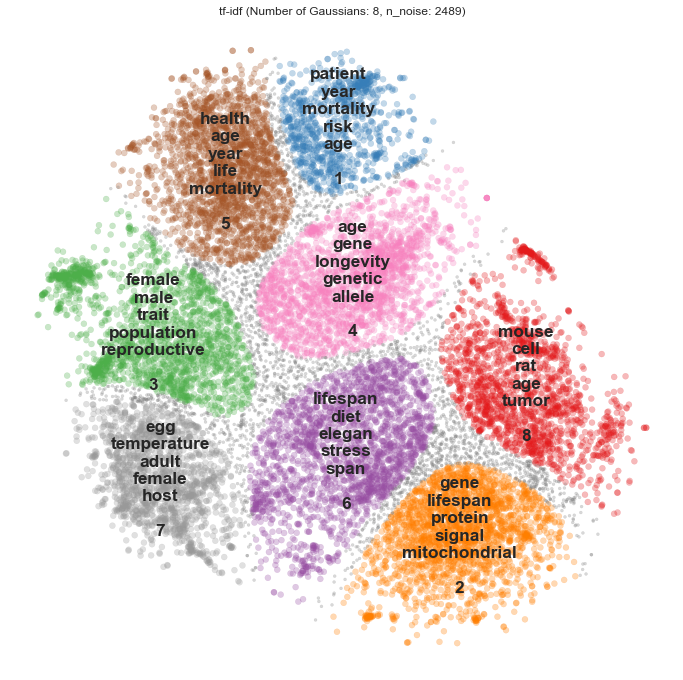

In [83]:
tfidf_desc = create_plot(tfidf_kw, ellipses=False, title='tf-idf')

In [ ]:
tfidf_desc = create_plot(tfidf_kw, ellipses=False, title='tf-idf - hyper', label_method=hypergeom_clusters)

In [80]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 10min 21s, sys: 5.68 s, total: 10min 27s
Wall time: 10min 40s


In [ ]:
yake_desc = create_plot(yake_keywords, ellipses=False, title='YAKE!')

/Users/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


0 1


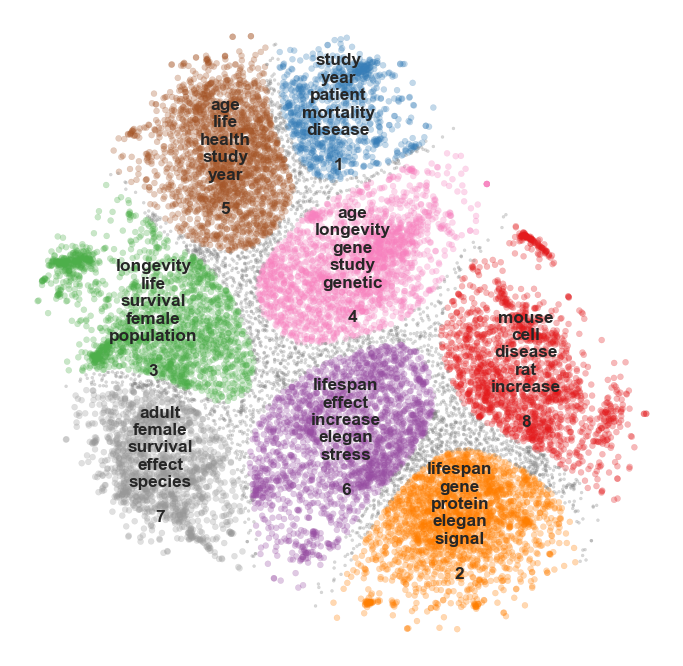

In [87]:
yake_desc = create_plot(yake_keywords, ellipses=False, title='YAKE!-hyper', label_method=hypergeom_clusters)
plt.savefig('document-map-yake-hyper.jpg', dpi=300)